<a href="https://colab.research.google.com/github/stanislavlia/DeepLearning.AI-specialization/blob/main/DeepNN_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

In [2]:
class DeepNN():
    def __init__(self, X, Y, dims_of_layers, activations,batch_size=None, alpha = 0.01, l2_reg = 0):
        #dims_of_layers - list of number of units in each layer (first element - num of features in input)
        #activations - activation function applied to each layer

        #dims_of_layers[0] - n of features in input
        #activations[0] - activation for first hidden layer
        #we support only 3 activation funcs: linear, sigmoid, relu

        #X.shape should be (n_features, m_examples)
        #Y.shape should be (1, m_examples)

        #regularization - regularization rate
        self.X = X
        self.Y = Y

        self.m_examples = X.shape[1]

        self.dims_of_layers = dims_of_layers
        self.n_layers = len(activations)

        self.activations = activations
        self.params = dict()

        #params for Adam
        self.V = dict()
        self.S = dict()

        #so far let's treat to hyperparams for Adam Beta1 and Beta2 as constants
        self.beta1 = 0.9
        self.beta2 = 0.99
        self.epsilon = 10 ** -8
        self.t = 0 #counter for Adam

        self.learning_history = []

        self.alpha = alpha
        self.l2_reg = l2_reg

        if batch_size is None:
          self.batch_size = self.m_examples
        else:
          self.batch_size = batch_size

        #setting cache dicts for backpropogation

        self.cache = dict()

    def initialize_params(self):
      #Now, we are going to use He-initialization of weights
        self.t = 0 #reset counter for Adam

        for i in range(1, len(self.activations) + 1):

            #setting parameters layer by layer
            self.params["W" + str(i)] = np.random.randn(self.dims_of_layers[i], self.dims_of_layers[i-1])
            #multiplying by constant according to He init
            self.params["W" + str(i)] *=  np.sqrt(2 / (self.dims_of_layers[i-1]))

            self.params["b" + str(i)] = np.zeros((self.dims_of_layers[i], 1))

            #setting params for Adam
            self.V["dW" + str(i)] = np.zeros(self.params["W" + str(i)].shape)
            self.S["dW" + str(i)] = np.zeros(self.params["W" + str(i)].shape)
            self.V["db" + str(i)] = np.zeros(self.params["b" + str(i)].shape)
            self.S["db" + str(i)] = np.zeros(self.params["b" + str(i)].shape)


    def make_minibatches(self, batch_size):
      #split X,y into minibatches and return list of (X_i, Y_i)

      #shuffle the data
      permuted_indices = np.random.permutation(self.X.shape[1])

      # Shuffle both X and y using the same permutation for rows
      X = self.X[:, permuted_indices]
      Y = self.Y[:, permuted_indices]

      batches = []
      complete_batches = self.m_examples // batch_size

      for k in range(0, complete_batches):

        #extracting a particular slice of data
        X_k = X[:, k * batch_size : (k + 1) * batch_size]
        Y_k = Y[:, k * batch_size : (k + 1) * batch_size]

        minibatch = (X_k, Y_k)
        batches.append(minibatch)

      #add incomplete batch in case we have remaining examples
      if (self.m_examples % batch_size != 0):
        X_k = X[:, complete_batches * batch_size : ]
        Y_k = Y[:, complete_batches * batch_size : ]
        minibatch = (X_k, Y_k)
        batches.append(minibatch)

      return (batches)



    def activation(self, Z, function="linear"):
        if function == "linear":
            return Z

        if function == "sigmoid":
            return 1 / (1 + np.exp(-Z))

        if function == "relu":
            return Z * (Z > 0)


    def deriv_activation(self, Z, function):
        if function == "linear":
            return 1.

        if function == "sigmoid":
            sigm_z = self.activation(Z, "sigmoid")

            return sigm_z *(1 - sigm_z)

        if function == "relu":
            return 1. * (Z > 0)



    def forward_propogation(self, X):

        #X.shape = (n_features, m_examples)

        A_prev = X
        self.cache["A0"]  = A_prev

        Z_current = np.dot(self.params["W1"], A_prev) + self.params["b1"]
        A_current = self.activation(Z_current, function=self.activations[0])

        self.cache["Z1"] = Z_current
        self.cache["A1"] = A_current

        for i in range(1, len(self.activations)):
            A_prev = A_current

            #A_prev - cache["A" + str(i)]
            Z_current = np.dot(self.params["W" + str(i+1)], A_prev) + self.params["b" + str(i+1)]
            A_current = self.activation(Z_current, function=self.activations[i])

            #keeping values in cache for backprop
            self.cache["Z" + str(i+1)] = Z_current
            self.cache["A" + str(i+1)] = A_current


        predictions = A_current

        return predictions

    def compute_reg_penalty(self):

      penalty = 0
      for l in range(1, self.n_layers + 1):
        W_l = self.params["W" + str(l)]
        penalty += np.sum(np.square(W_l))

      penalty = penalty * (self.l2_reg / (2 * self.m_examples))

      return penalty




    def compute_cost(self, predictions, cost_function): #TOFIX
        #leave cost func as a parameter
        #so that we can use it futher not only for classification

        if cost_function == "cross_entropy":

            #lets cut off a  tiny constant to avoid log0 problem
            epsilon = 10 ** -15

            predictions = np.clip(predictions, epsilon, 1-epsilon)

            #BinaryCrossEntropy

            cost = (self.Y * np.log(predictions) +
                    (1 - self.Y) * np.log(1 - (predictions)) ) * (-1 / self.m_examples)

            cost = np.sum(cost, axis=1, keepdims=True) #sum up the columns

        if cost_function == "mse":

            cost = np.sum(((predictions - self.Y) ** 2) * (2 / self.m_examples), axis=1, keepdims=True)


        #computing regularization penalty
        if self.l2_reg> 0:

            reg_penalty = self.compute_reg_penalty()
            cost += reg_penalty

        return cost

    def deriv_of_cost(self, Y, predictions, cost_function):

        if cost_function == "cross_entropy":

            #avoiding division by zero
            epsilon = 10 ** -15
            predictions = np.clip(predictions, epsilon, 1-epsilon)

            dAL = (predictions - Y) / (predictions * (1 - predictions))

        if cost_function == "mse":
            dAL = (predictions - Y)

        return dAL


    def back_propogation(self, Y ,predictions,  cost_func): #TOFIX

        L = self.n_layers

        grads_cache = dict()
        batch_size = predictions.shape[1]

        for i in range(L, 0, -1):
            if i == L:
                dA_i = self.deriv_of_cost(Y, predictions, cost_function=cost_func)
            else:

                dA_i = np.dot(self.params["W" + str(i+1)].T, grads_cache["dZ" + str(i+1)]) #ERROR MuSt be here
                #print("i =", i)
                # print("W=", self.params["W" + str(i+1)] )
                # print("dZ_next =", grads_cache["dZ" + str(i+1)])

                # print("W = ", self.params["W" + str(i+1)].T.shape)
                # print("W shape ", )
                # print("dZ shape" + str(i),  grads_cache["dZ" + str(i+1)].shape)
                #print("dA", dA_i)


            grads_cache["dA" + str(i)] = dA_i
            activation_i = self.activations[i-1]

            Z_i = self.cache["Z" + str(i)]
            A_prev = self.cache["A" + str(i-1)]
            W_i = self.params["W" + str(i)]

            #print("Activation = ", activation_i)
            dZ_i = dA_i * self.deriv_activation(Z_i, activation_i)

            #print("Sum of dZ_i", np.sum(dZ_i))

            #computing derivs for W, b

            #L2 regularization term
            l2_term = (self.l2_reg / batch_size) * W_i

            dW_i = (1 / batch_size) * np.dot(dZ_i, A_prev.T) + l2_term
            db_i = (1/ batch_size) * np.sum(dZ_i, axis=1, keepdims=True)


            #storing gradients
            grads_cache["dZ" + str(i)] = dZ_i
            grads_cache["dW" + str(i)] = dW_i
            grads_cache["db" + str(i)] = db_i

        return grads_cache

    def update_params(self, grads, optimizer="gd"): #TOFIX + opting: gd, momentum, adam

        for i in range(1, self.n_layers + 1):

            if optimizer == "gd":
              #updating by Gradient Descent
              self.params["W" + str(i)] -=  self.alpha * grads["dW" + str(i)]
              self.params["b" + str(i)] -= self.alpha * grads["db" + str(i)]

            #increment t-counter for Adam
            self.t += 1

            if optimizer == "momentum":
              self.V["dW" + str(i)] = (self.beta1 * self.V["dW" + str(i)]
                                       + (1 - self.beta1) * grads["dW" + str(i)])

              self.V["db" + str(i)] = (self.beta1 * self.V["db" + str(i)]
                                        + (1 - self.beta1) * grads["db" + str(i)])
              #bias correction
              self.V["dW" + str(i)] /= (1 - self.beta1 ** self.t)
              self.V["db" + str(i)] /= (1 - self.beta1 ** self.t)
              #update params by Grad Descent with momentum
              self.params["W" + str(i)] -=  self.alpha * self.V["dW" + str(i)]
              self.params["b" + str(i)] -= self.alpha * self.V["db" + str(i)]

            if optimizer == "adam":
              self.V["dW" + str(i)] = (self.beta1 * self.V["dW" + str(i)]
                                       + (1 - self.beta1) * grads["dW" + str(i)])

              self.V["db" + str(i)] = (self.beta1 * self.V["db" + str(i)]
                                        + (1 - self.beta1) * grads["db" + str(i)])

              self.S["dW" + str(i)] = (self.beta2 * self.S["dW" + str(i)]
                                       + (1 - self.beta2) * np.square(grads["dW" + str(i)]))
              self.S["db" + str(i)] = (self.beta2 * self.S["db" + str(i)]
                                       + (1 - self.beta2) * np.square(grads["db" + str(i)]))
              #bias correction
              self.V["dW" + str(i)] /= (1 - self.beta1 ** self.t)
              self.V["db" + str(i)] /= (1 - self.beta1 ** self.t)

              self.S["dW" + str(i)] /= (1 - self.beta2 ** self.t)
              self.S["db" + str(i)] /= (1 - self.beta2 ** self.t)

              #update params

              self.params["W" + str(i)] -=  self.alpha * self.V["dW" + str(i)] / (np.sqrt(self.S["dW" + str(i)]) + self.epsilon)
              self.params["b" + str(i)] -= self.alpha * self.V["db" + str(i)]  / (np.sqrt(self.S["db" + str(i)]) + self.epsilon)




    def fit(self, epochs=100, cost_func="cross_entropy", optimizer="gd", to_output=1 ,batch_out=False ): #TOFIX

        #fitting process

        #initialize random params

        
        history = []
        self.initialize_params()


        for epoch in range(0, epochs + 1):

            #split into batches
            minibatches = self.make_minibatches(self.batch_size)

            to_print = bool(epoch % (epochs // to_output) == 0)
            if to_print:
              print("EPOCH# ", epoch)
            for min_batch_num in range(len(minibatches)):
              X_i, Y_i = minibatches[min_batch_num]

              all_predictions = self.forward_propogation(self.X)
              local_predictions = self.forward_propogation(X_i)




              #computing cost function
              cost = np.round(self.compute_cost(all_predictions, cost_func), 6)
              if to_print and batch_out:
                print("       batch #{}, cost = {}".format(min_batch_num, cost))
                print()

              #computing gradients
              grads = self.back_propogation(Y_i, local_predictions, cost_func=cost_func)

              #update params using Gradient Descent
              self.update_params(grads, optimizer)
            history.append(float(cost))

        self.history = history

**Generating synthetic dataset to test implementation**

In [3]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#Trying on a data

np.random.seed(2004)

# Generate data for not admitted students
mean_not_admitted = [70, 75]
cov_not_admitted = [[100, 50], [50, 100]]
not_admitted = np.random.multivariate_normal(mean_not_admitted, cov_not_admitted, size=200)

# Generate data for admitted students
mean_admitted = [90, 90]
cov_admitted = [[100, 50], [50, 100]]
admitted = np.random.multivariate_normal(mean_admitted, cov_admitted, size=200)

# Combine the data
X = np.vstack((not_admitted, admitted)) / 100
y = np.hstack((np.zeros(200), np.ones(200)))



# Plot the generated data

# plt.figure(figsize=(11, 8))
# plt.scatter(not_admitted[:, 0], not_admitted[:, 1], label="Not Admitted")
# plt.scatter(admitted[:, 0], admitted[:, 1], label="Admitted")
# plt.xlabel("Test Score")
# plt.ylabel("Grade")
# plt.legend()
# plt.show()


#transform data for our model
X = X.T
y = y.reshape(1, -1)

In [10]:
dims = [X.shape[0], 5, 1]
activations = ["relu", "sigmoid"]


deepnn = DeepNN(X, y, dims, activations, batch_size=32, alpha=0.03)
deepnn.fit(epochs=4000, optimizer="gd")

gd_history = deepnn.history

deepnn2 = DeepNN(X, y, dims, activations, batch_size=32, alpha=0.03)
deepnn2.fit(epochs=4000, optimizer="momentum")

momentum_history = deepnn2.history

deepnn3 = DeepNN(X, y, dims, activations, batch_size=32, alpha=0.03)

deepnn3.fit(epochs=4000, optimizer="adam")
adam_history = deepnn3.history



EPOCH#  0
EPOCH#  4000
EPOCH#  0
EPOCH#  4000
EPOCH#  0
EPOCH#  4000


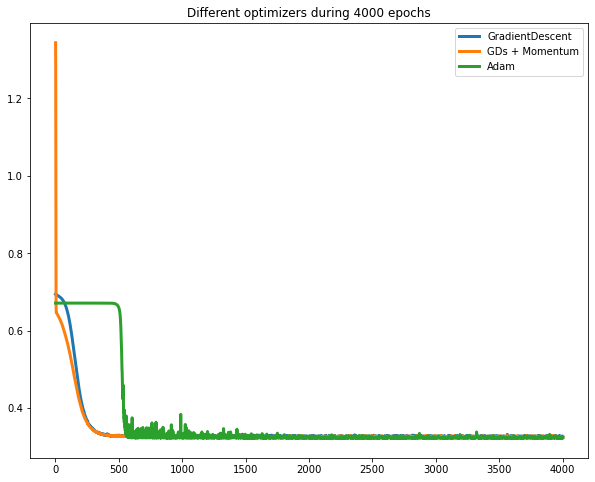

In [11]:

n_epochs = np.arange(1, len(gd_history) + 1, 1)

#Let's plot training with each optimizer


plt.figure(figsize=(10,8))
plt.title("Different optimizers during 4000 epochs")
plt.plot(n_epochs, gd_history, lw=3, label="GradientDescent")
plt.plot(n_epochs, momentum_history, lw=3, label="GDs + Momentum")
plt.plot(n_epochs, adam_history, lw=3, label="Adam")
plt.legend()

In [73]:
n_epochs.shape

(1001,)